In [2]:
#Load packages
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style



In [153]:
#Load data

In [3]:
contracts = pd.read_csv("contracts.csv")

In [4]:
merchants = pd.read_csv("merchants.csv")

In [5]:
order_lines  = pd.read_csv("order_lines.csv")

In [6]:
orders = pd.read_csv("orders.csv")

In [7]:
products = pd.read_csv("products.csv")

# 1. Data Integrity

It looks like there is an issue with lines 36190, 40255, 42759, 83333 in the "Products" table; the extra phrase \Mini\" shifted some columns over. It seems to be associated with the Category "Mini Bagniore".

I also noticed after working with the data that there are about 7000 rows in the "order_lines" data set for which  "is_warrantable" is False, but in the "products" table, "warranty_status" is "warrantable." This is something that should probably be addressed for consistency. 

#### Explore the data

In [8]:
#Merchants: Data on each merchant that has integrated Extend’s purchase protection product. 

print("merchants Summary")
#merchants.info()
#merchants.shape
merchants.head(2)

merchants Summary


,sortkey,name,createdat,enabled,approved,merchantcut,storetype
0,STORE::fd8f6538-a246-4fc8-b179-ca40fccfbb25,PowerMassagerPros,2019-08-13 23:00:31.000000,True,True,0.25,Sports & Fitness Equipment
1,STORE::780a27f2-578d-4455-818f-77b48453ffb9,ElectricSkatePark,2020-02-15 18:46:36.837000,True,True,0.20,Sports & Fitness Equipment


In [9]:
#Transform sortkey into a primary key to match against other tables
merchants['store_id'] = merchants['sortkey'].map(lambda x: x.lstrip('STORE::'))

In [120]:
#Contracts: Each warranty contract purchased by a consumer. 

print("Contracts Summary")
print(contracts.info())
#contracts.head(2)
#contracts.describe()

Contracts Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4891 entries, 0 to 4890
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   contract_id            4891 non-null   object 
 1   variant_id             4891 non-null   int64  
 2   store_id               4891 non-null   object 
 3   plan_id                4891 non-null   object 
 4   ordered_at             4891 non-null   object 
 5   plan_purchase_price    4891 non-null   float64
 6   is_refunded            4891 non-null   bool   
 7   contract_length_years  4891 non-null   float64
 8   line_item_id           4889 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 310.6+ KB
None


In [80]:
#Order_lines: Individual line items purchased within an order.

print("order_lines Summary")
order_lines.info()
#order_lines.head(2)
#order_lines.describe()

order_lines Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147041 entries, 0 to 147040
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   line_item_id            147041 non-null  int64  
 1   order_id                147041 non-null  int64  
 2   variant_id              144462 non-null  float64
 3   quantity                147041 non-null  int64  
 4   price                   147041 non-null  float64
 5   product_purchase_price  147041 non-null  float64
 6   discount_per_item       147041 non-null  float64
 7   is_warrantable          139889 non-null  object 
 8   is_warranty             147041 non-null  bool   
dtypes: bool(1), float64(4), int64(3), object(1)
memory usage: 9.1+ MB


In [122]:
#Find the total number of products sold that are warrantable
order_lines.value_counts('is_warrantable')


is_warrantable
False    85559
True     54330
dtype: int64

In [21]:
#order_lines['is_warrantable'].isnull()

In [20]:
#is_warranty = order_lines.value_counts('is_warranty')
#is_warranty

In [112]:
#Orders: Purchase data for Extend’s Shopify merchants

print("orders Summary")
orders.info()
#orders.head(2)
#orders.describe()

orders Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81943 entries, 0 to 81942
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          81943 non-null  int64  
 1   app_id            81943 non-null  int64  
 2   source_name       81943 non-null  object 
 3   ordered_at        81943 non-null  object 
 4   total_price       81943 non-null  float64
 5   subtotal_price    81943 non-null  float64
 6   total_discount    81943 non-null  float64
 7   shipping_country  81817 non-null  object 
 8   store_id          81943 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 5.6+ MB


In [154]:
#Products: List of all products sold by merchants, with product details and whether or not they are warrantable.

print("products Summary")
products.info()
#products.head(2)

products Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86598 entries, 0 to 86597
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store_id         86598 non-null  object 
 1   variant_id       86598 non-null  int64  
 2   category         79221 non-null  object 
 3   price            48828 non-null  float64
 4   warranty_status  84212 non-null  object 
 5   enabled          86526 non-null  object 
 6   approved         79603 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 4.6+ MB


There seems to be the most variation in terms of null values in the products dataset. 

In [72]:
warranty_status = products['warranty_status']
warranty_status.unique()

array([nan, 'non-warrantable', 'warrantable', 'pending',
       'review_required'], dtype=object)

In [57]:
warranty_status = products.value_counts('warranty_status')
warranty_status

warranty_status
non-warrantable    42597
warrantable        39559
pending             1295
review_required      761
dtype: int64

#### Create abbreviated tables for joining

In [94]:
stores = merchants[['name', 'store_id', 'merchantcut', 'storetype']]

In [38]:
orderlinessub = order_lines[['order_id', 'is_warrantable']]

In [42]:
ordersub = orders[['order_id', 'store_id', 'ordered_at','subtotal_price']]

In [10]:
productsXorder_lines = pd.merge(products,order_lines,on='variant_id')


In [95]:
#productsXorder_lines.head()
productsXorder_lines.shape

(135919, 15)

In [11]:
#Find number of warrantable products sold, according to products table
warrantable = productsXorder_lines["warranty_status"] == "warrantable"
Warr_prods = productsXorder_lines.loc[warrantable]

In [12]:
#Warr_prods.head()
Warr_prods.shape

(49166, 15)

In [81]:
Warr_prods['is_warranty'].unique()


array([False])

In [13]:
#Find number of warrantable products sold, according to order_lines table
is_warrantable = productsXorder_lines["is_warrantable"] == True
is_Warr_prods = productsXorder_lines.loc[is_warrantable]

In [14]:
is_Warr_prods.shape

(55296, 15)

In [19]:
#Find all products sold by merchant
storeXorders = pd.merge(merchants,orders,on='store_id')
storeXorders.head()

,sortkey,name,createdat,enabled,approved,merchantcut,storetype,store_id,order_id,app_id,source_name,ordered_at,total_price,subtotal_price,total_discount,shipping_country
0,STORE::fd8f6538-a246-4fc8-b179-ca40fccfbb25,PowerMassagerPros,2019-08-13 23:00:31.000000,True,True,0.25,Sports & Fitness Equipment,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2084368580662,580111,web,2020-04-10 21:41:58+00,249.99,249.99,0.0,United States
1,STORE::fd8f6538-a246-4fc8-b179-ca40fccfbb25,PowerMassagerPros,2019-08-13 23:00:31.000000,True,True,0.25,Sports & Fitness Equipment,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2070465445942,580111,web,2020-04-01 21:43:25+00,306.79,249.99,0.0,United States
2,STORE::fd8f6538-a246-4fc8-b179-ca40fccfbb25,PowerMassagerPros,2019-08-13 23:00:31.000000,True,True,0.25,Sports & Fitness Equipment,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2138211450934,294517,294517,2020-05-06 13:06:57+00,32.34,25.00,0.0,United States
3,STORE::fd8f6538-a246-4fc8-b179-ca40fccfbb25,PowerMassagerPros,2019-08-13 23:00:31.000000,True,True,0.25,Sports & Fitness Equipment,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2163481018422,580111,web,2020-05-18 15:36:54+00,222.08,199.99,0.0,United States
4,STORE::fd8f6538-a246-4fc8-b179-ca40fccfbb25,PowerMassagerPros,2019-08-13 23:00:31.000000,True,True,0.25,Sports & Fitness Equipment,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2132216086582,580111,web,2020-05-03 18:43:41+00,499.99,499.99,0.0,United States


In [20]:
storeXorders = storeXorders.drop(labels=['sortkey','createdat','enabled','approved', 'storetype', 'app_id', 'shipping_country','source_name'],  axis=1)

In [22]:
storeXorders.head()

,name,merchantcut,store_id,order_id,ordered_at,total_price,subtotal_price,total_discount
0,PowerMassagerPros,0.25,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2084368580662,2020-04-10 21:41:58+00,249.99,249.99,0.0
1,PowerMassagerPros,0.25,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2070465445942,2020-04-01 21:43:25+00,306.79,249.99,0.0
2,PowerMassagerPros,0.25,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2138211450934,2020-05-06 13:06:57+00,32.34,25.00,0.0
3,PowerMassagerPros,0.25,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2163481018422,2020-05-18 15:36:54+00,222.08,199.99,0.0
4,PowerMassagerPros,0.25,fd8f6538-a246-4fc8-b179-ca40fccfbb25,2132216086582,2020-05-03 18:43:41+00,499.99,499.99,0.0


# 2. Calculate attach rates


Overall attach rate: number of contracts sold / number of warrantable products sold\
I defined "Number of contracts sold" as the number of contract ids = 4891\
\
"Number of warrantable products sold" could either be:\
productsXorder_lines["is_warrantable"] = 55296; or\
order_lines["is_warrantable"] = 54330.\
\
For simplicity, I will use order_lines["is_warrantable"] = 54330\
Thus, \
 = 4891/54330 ~ 9%\
\
Now I will build a table to display more specific Attach Rates.

In [22]:
4891/55296

0.08845124421296297

In [23]:
4891/54330

0.09002392784833425

In [30]:
#Transform order dates to M/Y format
contracts['month_year'] = pd.to_datetime(contracts['ordered_at']).dt.to_period('M')


In [95]:
storeXwarranties = pd.merge(contracts, stores,on='store_id')

In [163]:
storeXwarranties.head()

,contract_id,variant_id,store_id,plan_id,ordered_at,plan_purchase_price,is_refunded,contract_length_years,line_item_id,month_year,name,merchantcut,storetype
0,001a6812-809e-4318-873d-4124742b7b69,30143018631191,0d92cbe4-2d26-4c81-ae4e-7ace36b6700b,10001-misc-elec-base-replace-1y,2020-05-07 19:26:23.000000,23.99,False,1.0,4.507782e+12,2020-05,PowerWashersDirect,0.25,Home and Garden
1,0d29c50f-78a1-463b-a884-8caa8863b863,14152461647907,0d92cbe4-2d26-4c81-ae4e-7ace36b6700b,10001-misc-elec-base-replace-2y,2020-05-07 13:53:21.000000,14.99,False,2.0,4.506840e+12,2020-05,PowerWashersDirect,0.25,Home and Garden
2,1b39d5b9-a9cb-4eec-a535-8b88a00d46b4,14152758853667,0d92cbe4-2d26-4c81-ae4e-7ace36b6700b,10001-misc-elec-base-replace-2y,2020-04-18 23:12:57.000000,79.99,False,2.0,4.449027e+12,2020-04,PowerWashersDirect,0.25,Home and Garden
3,227edb4a-4321-45f0-866e-122cbc9b3624,14153248964643,0d92cbe4-2d26-4c81-ae4e-7ace36b6700b,10001-misc-elec-base-replace-1y,2020-03-31 18:36:49.000000,5.99,False,1.0,4.397150e+12,2020-03,PowerWashersDirect,0.25,Home and Garden
4,1ecd2c67-26cb-4dd3-99f1-25a2210f1d39,15521526874147,0d92cbe4-2d26-4c81-ae4e-7ace36b6700b,10001-misc-elec-base-replace-1y,2020-05-18 14:35:47.000000,14.99,False,1.0,4.543949e+12,2020-05,PowerWashersDirect,0.25,Home and Garden


In [96]:
WarrSalesCount = storeXwarranties.groupby(['name','month_year']).count()

In [158]:
WarrSalesCount.head()

In [98]:
WarrSalesDollars = storeXwarranties.groupby(['name','month_year']).sum()

In [162]:
WarrSalesDollars.head()

variant_id  plan_purchase_price  \
name            month_year                                          
CarStereoIsland 2020-03     1331599267436256              1359.74   
                2020-04     1480854150586350              1614.96   
                2020-05     1599213253272022              2121.51   
DietTrackers    2020-04      186378374152990               398.61   
                2020-05     1124573953333584              4056.20   

                            is_refunded  contract_length_years  line_item_id  \
name            month_year                                                     
CarStereoIsland 2020-03               0                  170.0  4.215998e+14   
                2020-04               0                  194.0  5.996678e+14   
                2020-05               0                  238.0  6.481295e+14   
DietTrackers    2020-04               0                   17.0  4.790803e+13   
                2020-05               0                  138.0  4.599698e+14   

                            merchantcut  
name            month_year               
CarStereoIsland 2020-03            24.0  
                2020-04            33.5  
                2020-05            35.5  
DietTrackers    2020-04             3.0  
                2020-05            28.2

In [105]:
#Find total of sales of warranties by merchant and month, in dollars and units
WarrSalesGrouped = storeXwarranties.groupby(['name','month_year']).agg({'plan_purchase_price':['sum','count']})

In [161]:
WarrSalesGrouped.head()

In [43]:
ordersXstores = pd.merge(ordersub,stores,on='store_id')
ordersXstoresXlines = pd.merge(ordersXstores,orderlinessub,on='order_id')

In [46]:
ordersXstoresXlines.head()

,order_id,store_id,ordered_at,subtotal_price,name,merchantcut,is_warrantable,month_year
0,2084411998340,a5e80a29-c6af-446f-b569-f021e697c48c,2020-03-23 04:27:01+00,66.00,SecurityCamDirect,0.25,False,2020-03
1,2277522505860,a5e80a29-c6af-446f-b569-f021e697c48c,2020-05-25 18:12:01+00,997.37,SecurityCamDirect,0.25,True,2020-05
2,2478886322329,a5e80a29-c6af-446f-b569-f021e697c48c,2020-05-30 01:54:56+00,74.99,SecurityCamDirect,0.25,True,2020-05
3,2082113028228,a5e80a29-c6af-446f-b569-f021e697c48c,2020-03-21 23:37:08+00,99.00,SecurityCamDirect,0.25,True,2020-03
4,2101932621956,a5e80a29-c6af-446f-b569-f021e697c48c,2020-03-29 21:29:22+00,21.49,SecurityCamDirect,0.25,False,2020-03


In [45]:
ordersXstoresXlines['month_year'] = pd.to_datetime(ordersXstoresXlines['ordered_at']).dt.to_period('M')


C:\Users\manya\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [109]:
#Find total of sales warrantable products by merchant and month, in dollars and units
TotalSalesGrouped = ordersXstoresXlines.groupby(['name','month_year']).agg({'subtotal_price':['sum'],'is_warrantable':['count']})

In [198]:
TotalSalesGrouped.head()

subtotal_price is_warrantable
                                      sum          count
name            month_year                              
CarStereoIsland 2020-03         443235.96            919
                2020-04         611629.48           1619
                2020-05         784045.96           1816
DietTrackers    2020-04         658942.85           2218
                2020-05        1457655.22           5640

In [50]:
TotalSalesDollars = ordersXstoresXlines.groupby(['name','month_year']).sum()

In [199]:
TotalSalesDollars.head()

order_id  subtotal_price  merchantcut  \
name            month_year                                                   
CarStereoIsland 2020-03      1961995750369546       443235.96       244.50   
                2020-04      3510710398195940       611629.48       429.00   
                2020-05      4068491416849927       784045.96       484.75   
DietTrackers    2020-04      4860999549909430       658942.85       669.90   
                2020-05     12994922087220670      1457655.22      1739.10   

                            AR_percent_by_Dollars  
name            month_year                         
CarStereoIsland 2020-03                  0.306776  
                2020-04                  0.264042  
                2020-05                  0.270585  
DietTrackers    2020-04                  0.060492  
                2020-05                  0.278269

In [53]:
TotalSalesCount = ordersXstoresXlines.groupby(['name','month_year']).count()

In [200]:
TotalSalesCount.head()

order_id  store_id  ordered_at  subtotal_price  \
name            month_year                                                   
CarStereoIsland 2020-03          978       978         978             978   
                2020-04         1716      1716        1716            1716   
                2020-05         1939      1939        1939            1939   
DietTrackers    2020-04         2233      2233        2233            2233   
                2020-05         5797      5797        5797            5797   

                            merchantcut  is_warrantable  AR_percent_by_Units  
name            month_year                                                    
CarStereoIsland 2020-03             978             919            10.446137  
                2020-04            1716            1619             8.276714  
                2020-05            1939            1816             7.819383  
DietTrackers    2020-04            2233            2218             0.450857  
                2020-05            5797            5640             1.666667

In [113]:
AttachRates = pd.merge(TotalSalesGrouped, WarrSalesGrouped, on=['name','month_year'])

In [116]:
AttachRates.columns =['product_prices_sum', 'product_count', 'warranty_price_sum', 'warranty_count']

In [118]:
AttachRates['AR_percent_by_Units'] = (WarrSalesCount['contract_id']*100/TotalSalesCount['is_warrantable'])

In [119]:
AttachRates['AR_percent_by_Dollars'] = (WarrSalesDollars['plan_purchase_price']*100/TotalSalesDollars['subtotal_price'])

In [125]:
AttachRates['merchantcut']=WarrSalesDollars['merchantcut']/WarrSalesCount['contract_id']

In [126]:
#All information about warranty and products sales totals and attach rates
AttachRates

product_prices_sum  product_count  \
name               month_year                                      
CarStereoIsland    2020-03           4.432360e+05            919   
                   2020-04           6.116295e+05           1619   
                   2020-05           7.840460e+05           1816   
DietTrackers       2020-04           6.589428e+05           2218   
                   2020-05           1.457655e+06           5640   
DroneWarehouse     2020-05           5.778559e+06          48067   
ElectricSkatePark  2020-03           5.794632e+04             74   
                   2020-04           7.970146e+04             91   
                   2020-05           1.441920e+05            158   
FitnessWareables   2020-03           1.618938e+05            497   
                   2020-04           7.494471e+05           2683   
                   2020-05           1.771663e+06           6448   
HVAC4U             2020-03           3.614348e+05            946   
                   2020-04           4.681148e+05           1367   
                   2020-05           6.358835e+05           1976   
HomeSecurityMart   2020-03           2.247676e+05           1480   
                   2020-04           2.447805e+05           1508   
                   2020-05           1.229398e+06           4618   
LuxuryWatchDepot   2020-04           5.921484e+06           1358   
                   2020-05           6.297062e+06           1242   
Photos4Grandma     2020-03           2.137236e+05           1098   
                   2020-04           8.082059e+05           4014   
                   2020-05           1.294863e+06           6370   
PowerMassagerPros  2020-03           5.757395e+05           1672   
                   2020-04           8.368362e+05           2472   
                   2020-05           6.838022e+05           2102   
PowerWashersDirect 2020-03           3.622408e+05            850   
                   2020-04           7.619313e+05           2468   
                   2020-05           1.057975e+06           2656   
RefurbPCLand       2020-03           3.617931e+05           1090   
                   2020-04           2.963749e+04             57   
SecurityCamDirect  2020-03           1.108846e+05            876   
                   2020-04           1.675591e+05           1482   
                   2020-05           1.327613e+05           1233   
SiiickHeadphones   2020-03           4.091896e+04            729   
                   2020-04           1.159463e+05           1366   
                   2020-05           1.527900e+05           1711   
SkateboardsUSA     2020-03           1.590533e+06           1587   
                   2020-04           2.525342e+06           2877   
                   2020-05           3.051101e+06           3454   

                               warranty_price_sum  warranty_count  \
name               month_year                                       
CarStereoIsland    2020-03                1359.74              96   
                   2020-04                1614.96             134   
                   2020-05                2121.51             142   
DietTrackers       2020-04                 398.61              10   
                   2020-05                4056.20              94   
DroneWarehouse     2020-05                3231.09             441   
ElectricSkatePark  2020-03                 647.95               7   
                   2020-04                1045.95               9   
                   2020-05                2286.86              22   
FitnessWareables   2020-03                2294.51              49   
                   2020-04                9076.54             246   
                   2020-05               20460.23             577   
HVAC4U             2020-03                3975.50              61   
                   2020-04                5330.09              98   
                   2020-05                9964.51             193   
H

Text(0, 0.5, 'AR as Percent')

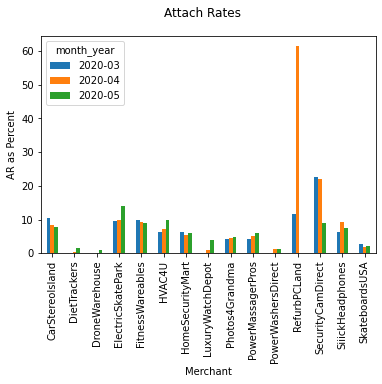

In [197]:
AttachRates.groupby(['name','month_year']).sum().unstack().plot(kind='bar',y='AR_percent_by_Units')
plt.suptitle("Attach Rates")
plt.xlabel("Merchant")
plt.ylabel("AR as Percent")
#plt.text(1, 4, string, fontsize=15, color="red")

Low outlier: DietTrackers\
High outlier: SecurityCamDirect (RefurbPCLand is the biggest outlier but SCD is more consistently high over time. RCPCL would also be interesting to investigate and see why it jumped.)


In [164]:
orderinfo = pd.merge(ordersub, order_lines, on='order_id')

In [ ]:
orderinfo.info()

In [167]:
orderswarranties = pd.merge(orderinfo, contracts, how='outer', on=['line_item_id','store_id'])

### SKU Analysis for SecurityCamDirect

In [169]:
scd = orderswarranties["store_id"] == "a5e80a29-c6af-446f-b569-f021e697c48c"
SecurityCamDirect = orderswarranties[scd]

In [170]:
SCD = SecurityCamDirect.groupby(['variant_id_x']).agg({'product_purchase_price':['sum','size'], 'plan_purchase_price':['sum','count']})

In [171]:
SCD

product_purchase_price      plan_purchase_price      
                                sum size                 sum count
variant_id_x                                                      
2.861737e+10               12239.56  384              451.37    63
2.868668e+10                 104.97    3                0.00     0
2.916532e+10                9874.12  471              241.22    68
2.919999e+10                4744.53  147               12.98     2
4.404234e+10                 431.76   24                0.00     0
...                             ...  ...                 ...   ...
3.381937e+13                 223.84   16                0.00     0
3.381937e+13                  63.92    8                0.00     0
3.381937e+13                 139.93    7                0.00     0
3.388875e+13                 154.00    2                0.00     0
3.389749e+13                 122.00    1                0.00     0

[77 rows x 4 columns]

In [172]:
SCD.columns =['product_price_sum', 'product_count', 'warranty_price_sum', 'warranty_count']

In [173]:
SCD.head()

,product_price_sum,product_count,warranty_price_sum,warranty_count
variant_id_x,,,,
2.861737e+10,12239.56,384,451.37,63
2.868668e+10,104.97,3,0.00,0
2.916532e+10,9874.12,471,241.22,68
2.919999e+10,4744.53,147,12.98,2
4.404234e+10,431.76,24,0.00,0


In [174]:
SCD['attach_rate_perc']= (SCD.warranty_count/SCD.product_count)*100

In [175]:
SCD['margin_rate_perc']= (SCD.warranty_price_sum/SCD.product_price_sum)*100

In [176]:
SCD = SCD.sort_values(by = ['attach_rate_perc'], axis=0, ascending=False)

In [177]:
SCD['product_price']= SCD.product_price_sum/SCD.product_count

In [178]:
SCD['warranty_price']= SCD.warranty_price_sum/SCD.warranty_count

In [179]:
SCD['warrantyasPercentofPrice']= (SCD.warranty_price/SCD.product_price)*100

In [180]:
SCD.head(15)

,product_price_sum,product_count,warranty_price_sum,warranty_count,attach_rate_perc,margin_rate_perc,product_price,warranty_price,warrantyasPercentofPrice
variant_id_x,,,,,,,,,
3.057674e+13,623.78,22,64.90,10,45.454545,10.404309,28.353636,6.490000,22.889480
3.057300e+13,68611.88,812,3120.87,213,26.231527,4.548585,84.497389,14.651972,17.340147
1.144446e+13,447.92,8,23.98,2,25.000000,5.353635,55.990000,11.990000,21.414538
4.516187e+10,29431.49,726,1087.82,148,20.385675,3.696109,40.539242,7.350135,18.130914
1.155779e+13,6184.96,104,206.31,19,18.269231,3.335672,59.470769,10.858421,18.258417
1.155789e+13,2309.67,33,72.94,6,18.181818,3.158027,69.990000,12.156667,17.369148
1.155777e+13,2729.61,39,120.93,7,17.948718,4.430303,69.990000,17.275714,24.683118
1.164230e+13,3966.32,68,124.88,12,17.647059,3.148510,58.328235,10.406667,17.841559
1.216808e+13,7804.69,131,272.77,23,17.557252,3.494950,59.577786,11.859565,19.906019


Home security cameras in the 40 to 60 dollar range seem to do really well. The item "cloud" does not seem to do well. 

### SKU Analysis for DietTrackers

In [182]:
dt = orderswarranties["store_id"] == "c18e4014-49ee-4f3d-8813-c7a9f2e407b9"
DietTrackers = orderswarranties[dt]

In [183]:
DietTrackers.head()

,order_id,store_id,ordered_at_x,subtotal_price,line_item_id,variant_id_x,quantity,price,product_purchase_price,discount_per_item,is_warrantable,is_warranty,contract_id,variant_id_y,plan_id,ordered_at_y,plan_purchase_price,is_refunded,contract_length_years,month_year
32,2.157249e+12,c18e4014-49ee-4f3d-8813-c7a9f2e407b9,2020-04-17 00:13:37+00,254.15,4.724959e+12,8.132411e+12,1.0,299.00,299.00,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
47,2.161660e+12,c18e4014-49ee-4f3d-8813-c7a9f2e407b9,2020-04-18 15:37:08+00,134.73,4.733618e+12,2.872983e+10,1.0,65.99,65.99,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
48,2.161660e+12,c18e4014-49ee-4f3d-8813-c7a9f2e407b9,2020-04-18 15:37:08+00,134.73,4.733618e+12,3.033153e+13,1.0,2.75,2.75,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
49,2.161660e+12,c18e4014-49ee-4f3d-8813-c7a9f2e407b9,2020-04-18 15:37:08+00,134.73,4.733618e+12,2.872983e+10,1.0,65.99,65.99,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
80,2.203269e+12,c18e4014-49ee-4f3d-8813-c7a9f2e407b9,2020-05-03 13:08:00+00,71.40,4.816051e+12,1.235591e+13,1.0,6.00,6.00,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [184]:
DT = DietTrackers.groupby(['variant_id_x']).agg({'product_purchase_price':['sum','size'], 'plan_purchase_price':['sum','count']})

In [186]:
DT.head()

product_purchase_price      plan_purchase_price      
                                sum size                 sum count
variant_id_x                                                      
2.872982e+10                1349.55   45                 0.0     0
2.872982e+10                5401.28   83                 0.0     0
2.872982e+10                2114.87   13                 0.0     0
2.872982e+10                 209.93    7                 0.0     0
2.872982e+10                1979.70   30                 0.0     0

In [187]:
DT.columns =['product_price_sum', 'product_count', 'warranty_price_sum', 'warranty_count']

In [188]:
DT['attach_rate_perc']= (DT.warranty_count/DT.product_count)*100

In [189]:
DT['margin_rate_perc']= (DT.warranty_price_sum/DT.product_price_sum)*100

In [190]:
DT['product_price']= DT.product_price_sum/DT.product_count

In [191]:
DT['warranty_price']= DT.warranty_price_sum/DT.warranty_count

In [192]:
DT['warrantyasPercentofPrice']= (DT.warranty_price/DT.product_price)*100

In [193]:
DT = DT.sort_values(by = ['attach_rate_perc'], axis=0, ascending=False)

In [195]:
DT.head(15)

,product_price_sum,product_count,warranty_price_sum,warranty_count,attach_rate_perc,margin_rate_perc,product_price,warranty_price,warrantyasPercentofPrice
variant_id_x,,,,,,,,,
5.965748e+12,36023.00,41,871.97,6,14.634146,2.420592,878.609756,145.328333,16.540715
1.038179e+12,1764.00,63,56.01,9,14.285714,3.175170,28.000000,6.223333,22.226190
2.802460e+13,21419.50,158,372.82,18,11.392405,1.740564,135.566456,20.712222,15.278280
3.180731e+13,6175.00,19,92.98,2,10.526316,1.505749,325.000000,46.490000,14.304615
3.088240e+13,3885.00,29,80.97,3,10.344828,2.084170,133.965517,26.990000,20.146976
8.132402e+12,54672.15,183,714.82,18,9.836066,1.307466,298.754918,39.712222,13.292575
7.926612e+12,32806.00,94,374.91,9,9.574468,1.142809,349.000000,41.656667,11.936008
8.132411e+12,31096.00,105,444.91,9,8.571429,1.430763,296.152381,49.434444,16.692233
6.982595e+12,70777.20,203,774.83,17,8.374384,1.094745,348.656158,45.578235,13.072546


All of these items seem to be something called a diffuser.

In [116]:
#Warr_prods[['warranty_status','is_warrantable']]
warranty_status = Warr_prods['warranty_status']
warranty_status.unique()

array(['warrantable'], dtype=object)

In [117]:
is_warrantable = Warr_prods["is_warrantable"] == False
is_warr_prods = Warr_prods.loc[is_warrantable]

In [118]:
is_warr_prods.shape

(8265, 15)

In [121]:
Warr_prods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49166 entries, 2304 to 135760
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   store_id                49166 non-null  object 
 1   variant_id              49166 non-null  int64  
 2   category                25034 non-null  object 
 3   price_x                 49166 non-null  float64
 4   warranty_status         49166 non-null  object 
 5   enabled                 49166 non-null  object 
 6   approved                49156 non-null  object 
 7   line_item_id            49166 non-null  int64  
 8   order_id                49166 non-null  int64  
 9   quantity                49166 non-null  int64  
 10  price_y                 49166 non-null  float64
 11  product_purchase_price  49166 non-null  float64
 12  discount_per_item       49166 non-null  float64
 13  is_warrantable          49139 non-null  object 
 14  is_warranty             49166 non-

In [112]:
147041 - 139889              

7152